## Import

In [1]:
import sys
sys.path.append(r'C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\src\facility_location_Bergen\custome_modules')

In [2]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
# Ignore the ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
import os
import dill
import pyproj
import folium
import requests
import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
from scipy import stats
import plotly.graph_objects as go
from sklearn.utils import resample
import cartopy.io.img_tiles as cimgt
from plotly.subplots import make_subplots
from urllib.request import urlopen, Request
from log import print_INFO_message_timestamp, print_INFO_message
from facility_location import AdjacencyMatrix, FacilityLocation, FacilityLocationReport

## Solution analysis

### Loading data

#### Exact solution

In [20]:
times = ["all_day", "all_day_free_flow", "morning", "midday", "afternoon"]
facilities_number = 3

In [21]:
print_INFO_message_timestamp("Loading exact solutions...")

fls_exact = {}

for time in times:
    print_INFO_message(f"Loading exact solution for {time}")
    path = rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\07_model_output\{facilities_number}_locations\deterministic_exact_solutions\exact_solution_{time}.pkl"
    fls_exact[time] = FacilityLocation.load(path)

[06/02/23 12:45:02] INFO     Loading exact solutions...
                    INFO     Loading exact solution for all_day
                    INFO     Loading exact solution for all_day_free_flow
                    INFO     Loading exact solution for morning
                    INFO     Loading exact solution for midday
                    INFO     Loading exact solution for afternoon


#### dfs for solution comparison

In [7]:
root = r"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\08_reporting"
paths = [p for p in os.listdir(root) if ("solution_vs_scenario" in p) and ("worst" not in p)]
paths_worst = [p for p in os.listdir(root) if ("solution_vs_scenario" in p) and ("worst" in p)]

In [8]:
paths_worst

['solution_vs_scenario_all_day_free_flow_afternoon_weight_worst.pkl',
 'solution_vs_scenario_all_day_free_flow_all_day_weight2_worst.pkl',
 'solution_vs_scenario_all_day_free_flow_all_day_weight_worst.pkl',
 'solution_vs_scenario_all_day_free_flow_midday_weight_worst.pkl',
 'solution_vs_scenario_all_day_free_flow_morning_weight_worst.pkl']

In [57]:
dfs = {}

for path in paths:
    with open(os.path.join(root, path), "rb") as f:
        dfs[tuple(path.removesuffix(".pkl").split("_")[-2:])] = pkl.load(f)

In [58]:
dfs_worst = {}

for path in paths_worst:
    with open(os.path.join(root, path), "rb") as f:
        dfs_worst[tuple(path.removesuffix(".pkl").split("_")[-3:-1])] = pkl.load(f)

#### Adj matrix mapping

In [9]:
adj_mappings = {}

for time in times:
    if time != "all_day_free_flow":
        print_INFO_message(f"Loading adj mapping for {time}")
        path = rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\adj_mapping_{time}.pkl"
        with open(path, "rb") as f:
            adj_mappings[time] = dill.load(f)

                    INFO     Loading adj mapping for all_day
                    INFO     Loading adj mapping for morning
                    INFO     Loading adj mapping for midday
                    INFO     Loading adj mapping for afternoon


#### Average graph

In [126]:
average_graphs = {}

for time in times:
    if time != "all_day_free_flow":
        print_INFO_message(f"Loading adj matrix for {time}")
        path = rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\average_graph_{time}.pkl"
        with open(path, "rb") as f:
            average_graphs[time] = pkl.load(f)

                    INFO     Loading adj matrix for all_day
                    INFO     Loading adj matrix for morning
                    INFO     Loading adj matrix for midday
                    INFO     Loading adj matrix for afternoon


In [132]:
worst_average_graphs = {}

for time in times:
    if time != "all_day_free_flow":
        print_INFO_message(f"Loading adj matrix for {time}")
        path = rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\worst_average_graph_{time}.pkl"
        with open(path, "rb") as f:
            worst_average_graphs[time] = pkl.load(f)

                    INFO     Loading adj matrix for all_day
                    INFO     Loading adj matrix for morning
                    INFO     Loading adj matrix for midday
                    INFO     Loading adj matrix for afternoon


### Exact solution analysis

In [22]:
print_INFO_message_timestamp("Objective value for the Exact solution")
for time, fl_exact in fls_exact.items():
    print_INFO_message(f"{time}: {round(fl_exact.solution_value/60,3)} minutes")

[06/02/23 12:57:44] INFO     Objective value for the Exact solution
                    INFO     all_day: 19.334 minutes
                    INFO     all_day_free_flow: 17.173 minutes
                    INFO     morning: 19.884 minutes
                    INFO     midday: 19.714 minutes
                    INFO     afternoon: 20.708 minutes


In [24]:
report_exact = FacilityLocationReport(fls_exact)

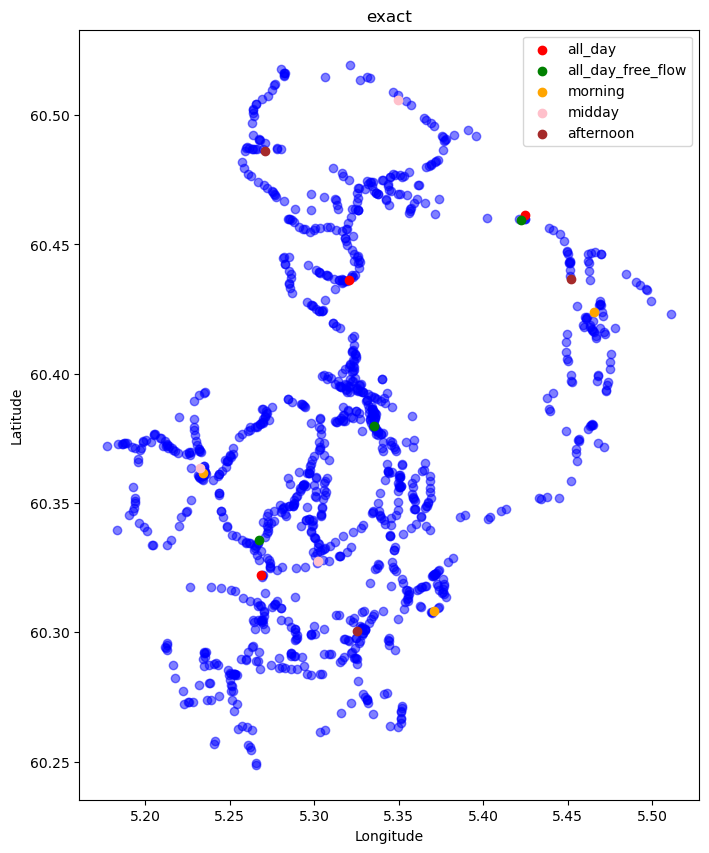

In [25]:
report_exact.graphical_keys_solutions_comparison()

- Let O denote the objective function, t denote time, and x denotes the decision variables. 
- Let x_ff be the value of the decision variables obtained in the free-flow setting. 

For each time condition t, we want to compute the value of the objective function O(x_ff, t) when fixing x to be x_ff.

### Retrieve average graphs

In [14]:
fls_exact["all_day_free_flow"].locations_coordinates

[geometry    POINT (5.42497 60.45984)
 Name: 4580, dtype: geometry,
 geometry    POINT (5.33506 60.38002)
 Name: 1442, dtype: geometry]

In [15]:
sv = fls_exact["all_day_free_flow"].solution_value/60
sv

21.129030663681966

In [16]:
a = fls_exact["all_day_free_flow"].adjacency_matrix
print(a.shape)
np.where(a/60 == sv, a, 0).nonzero()

(5602, 5602)


(array([1442], dtype=int64), array([646], dtype=int64))

In [17]:
print(f'source: {adj_mappings["all_day"][1442]}\ndestination: {adj_mappings["all_day"][646]}')

source: (5.33506, 60.38002)
destination: (5.26524, 60.24877)


In [18]:
a = nx.dijkstra_path_length(G=average_graphs["all_day"], 
                            source=adj_mappings["all_day"][1442], 
                            target=adj_mappings["all_day"][646],
                            weight="weight2")/60

b = fls_exact["all_day_free_flow"].adjacency_matrix[1442, 646]/60

print(f"shortest path lenght: {a}\nadj matrix: {b}")

shortest path lenght: 21.129030663681966
adj matrix: 21.129030663681966


### Compare solution under different scenarios

In [20]:
def solution_vs_scenario(time_solution, time_scenario, weight="weight2", worst=False):
    
    # Load the exact solution
    print_INFO_message_timestamp(f"Loading exact solution for {time_solution}")
    path = rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\07_model_output\exact_solutions\exact_solution_{time_solution}.pkl"
    fls_exact_solution = FacilityLocation.load(path)
    
    # Load the average graph
    print_INFO_message(f"Loading adj matrix for {time_scenario}")
    if worst:
        path = rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\worst_average_graph_{time_scenario}.pkl"
    else:
        path = rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\average_graph_{time_scenario}.pkl"
    
    with open(path, "rb") as f:
        average_graph = pkl.load(f)
    
    # extract the coordinates of the exact solution
    ff_solutions_location = fls_exact_solution.locations_coordinates
    
    # compute the distance from the exact solution to all the other nodes in the graph
    print_INFO_message_timestamp(f"Compute the distance from the {time_solution} solution to all the other nodes in the {time_scenario} graph")
    
    temporal_distances = {ff_solutions_location[i].geometry.coords[0]: [] for i in range(len(ff_solutions_location))}

    for i, node in enumerate(average_graph):
        if i%500 == 0:
            print_INFO_message(f"{i} out of {len(average_graph.nodes)}")
            
        keys = list(temporal_distances.keys())
        temporal_distances[keys[0]].append(
            (node, nx.dijkstra_path_length(G=average_graph, 
                                source=keys[0], 
                                target=node,
                                weight=weight))
            ) 
        
        temporal_distances[keys[1]].append(
            (node, nx.dijkstra_path_length(G=average_graph, 
                                source=keys[1], 
                                target=node,
                                weight=weight))
            )
    
    # create a dataframe with the distance from the exact solution to all the other nodes in the graph
    d = {"source": [], "target": [], "travel_time": []}
    
    for key, value in temporal_distances.items():
        for node, distance in value:
            d["source"].append(key)
            d["target"].append(node)
            d["travel_time"].append(round(distance/60, 3))
            
    return pd.DataFrame(d)

In [21]:
def get_minimum_distances(df):
    return df.groupby("target").min().reset_index()

In [22]:
keys = list(dfs.keys())
keys

[('afternoon', 'weight'),
 ('day', 'weight'),
 ('day', 'weight2'),
 ('midday', 'weight'),
 ('morning', 'weight')]

#### Free-flow

In [23]:
df_all_day_ff_min = get_minimum_distances(dfs[("day", "weight2")])

In [24]:
df_all_day_ff_min.sort_values(by="travel_time", ascending=False).reset_index().head(5)

,index,target,source,travel_time
0,1090,"(5.26524, 60.24877)","(5.33506, 60.38002)",21.129
1,1106,"(5.26549, 60.24934)","(5.33506, 60.38002)",21.046
2,1122,"(5.26583, 60.2503)","(5.33506, 60.38002)",20.906
3,1094,"(5.26531, 60.25128)","(5.33506, 60.38002)",20.761
4,1066,"(5.26457, 60.25207)","(5.33506, 60.38002)",20.638


In [25]:
df_all_day_ff_min["travel_time"].mean()

10.612385576579793

In [26]:
a = round(fls_exact["all_day_free_flow"].solution_value/60, 3)
b = dfs[("day", "weight2")].groupby("target").min().sort_values(by="travel_time", ascending=False).iloc[0].travel_time

print(f"exact solution: {a}\nff approximation: {b}\nrel_difference: {round(abs(a-b)/a * 100,3)}")

exact solution: 21.129
ff approximation: 21.129
rel_difference: 0.0


#### All-day

In [61]:
df_all_day_min = get_minimum_distances(dfs[("day", "weight")])
df_worst_all_day_min = get_minimum_distances(dfs_worst[("day", "weight")])

In [70]:
print(f'average time: {df_all_day_min["travel_time"].mean()}\naverage worst time: {df_worst_all_day_min["travel_time"].mean()}')

average time: 12.336253302392002
average worst time: 13.885288468404141


In [67]:
a = round(fls_exact["all_day"].solution_value/60, 3)

b = df_all_day_min.sort_values(by="travel_time", ascending=False).iloc[0].travel_time
b_worst = df_worst_all_day_min.sort_values(by="travel_time", ascending=False).iloc[0].travel_time

rel_difference_all_day = round(abs(a-b)/a * 100,3)
rel_difference_all_day_worst = round(abs(a-b_worst)/a * 100,3)

print(f"exact solution: {a}\nff approximation: {b}\nrel_difference: {rel_difference_all_day}\nrel_difference_worst: {rel_difference_all_day_worst}")

exact solution: 23.286
ff approximation: 24.086
rel_difference: 3.436
rel_difference_worst: 18.548


#### Morning

In [68]:
df_morning_min = get_minimum_distances(dfs[("morning", "weight")])
df_worst_morning_min = get_minimum_distances(dfs_worst[("morning", "weight")])

In [71]:
print(f'average time: {df_morning_min["travel_time"].mean()}\naverage worst time: {df_worst_morning_min["travel_time"].mean()}')

average time: 11.967994287754372
average worst time: 13.21252784719743


In [72]:
a = round(fls_exact["morning"].solution_value/60, 3)

b = df_morning_min.sort_values(by="travel_time", ascending=False).iloc[0].travel_time
b_worst = df_worst_morning_min.sort_values(by="travel_time", ascending=False).iloc[0].travel_time

rel_difference_morning = round(abs(a-b)/a * 100,3)
rel_difference_morning_worst = round(abs(a-b_worst)/a * 100,3)

print(f"exact solution: {a}\nff approximation: {b}\nrel_difference: {rel_difference_morning}\nrel_difference_worst: {rel_difference_morning_worst}")

exact solution: 22.661
ff approximation: 23.49
rel_difference: 3.658
rel_difference_worst: 13.733


#### Midday

In [73]:
df_midday_min = get_minimum_distances(dfs[("midday", "weight")])
df_worst_midday_min = get_minimum_distances(dfs_worst[("midday", "weight")])

In [74]:
print(f'average time: {df_midday_min["travel_time"].mean()}\naverage worst time: {df_worst_midday_min["travel_time"].mean()}')

average time: 12.100898429132455
average worst time: 13.073073545162444


In [75]:
a = round(fls_exact["midday"].solution_value/60, 3)

b = df_midday_min.sort_values(by="travel_time", ascending=False).iloc[0].travel_time
b_worst = df_worst_midday_min.sort_values(by="travel_time", ascending=False).iloc[0].travel_time

rel_difference_midday = round(abs(a-b)/a * 100,3)
rel_difference_midday_worst = round(abs(a-b_worst)/a * 100,3)

print(f"exact solution: {a}\nff approximation: {b}\nrel_difference: {rel_difference_midday}\nrel_difference_worst: {rel_difference_midday_worst}")

exact solution: 22.117
ff approximation: 23.501
rel_difference: 6.258
rel_difference_worst: 16.512


#### Afternoon

In [76]:
df_afternoon_min = get_minimum_distances(dfs[("afternoon", "weight")])
df_worst_afternoon_min = get_minimum_distances(dfs_worst[("afternoon", "weight")])

In [77]:
print(f'average time: {df_afternoon_min["travel_time"].mean()}\naverage worst time: {df_worst_afternoon_min["travel_time"].mean()}')

average time: 13.003315423063192
average worst time: 15.794484826847555


In [78]:
a = round(fls_exact["afternoon"].solution_value/60, 3)

b = df_afternoon_min.sort_values(by="travel_time", ascending=False).iloc[0].travel_time
b_worst = df_worst_afternoon_min.sort_values(by="travel_time", ascending=False).iloc[0].travel_time

rel_difference_afternoon = round(abs(a-b)/a * 100,3)
rel_difference_afternoon_worst = round(abs(a-b_worst)/a * 100,3)

print(f"exact solution: {a}\nff approximation: {b}\nrel_difference: {rel_difference_afternoon}\nrel_difference_worst: {rel_difference_afternoon_worst}")

exact solution: 23.232
ff approximation: 26.046
rel_difference: 12.113
rel_difference_worst: 51.296


### Reporting

In this section, the following steps are performed:
1. **Compare the objective function value** under different scenarios, for a specif set of solution locations
   
2. Given the matrix containing the travel times between all OD pairs, for a specific solution, **compare the distribution** of travel times between OD pairs under different scenarios
   
3. **Dispaly the path** associated to the solutions at step1 

#### Step 1: Compare the objective function value under different scenarios, for a specif set of solution locations

In [81]:
rel_diffs = [rel_difference_all_day, rel_difference_morning, rel_difference_midday, rel_difference_afternoon]
rel_diffs_worst = [rel_difference_all_day_worst, rel_difference_morning_worst, rel_difference_midday_worst, rel_difference_afternoon_worst]

In [88]:
fig = make_subplots(rows=1, cols=2,)
fig.update_layout(title="<b>Relative difference between the exact solution and the free flow approximation<b>",
                  title_pad_l=150,
                  height=500,
                  width=1200,
                  xaxis_title="time of the day",
                  yaxis_title="relative difference [%]")

fig.update_yaxes(range=[0, 100])

fig.add_trace(go.Bar(y=rel_diffs, 
                     name="average scenario",
                     x=["all_day", "morning", "midday", "afternoon"],), row=1, col=1)

fig.add_trace(go.Bar(y=rel_diffs_worst,
                     name="average worst scenario",
                     x=["all_day", "morning", "midday", "afternoon"],), row=1, col=2)

#### Step 2: Compare the distribution of travel times between OD pairs under different scenarios

In [89]:
df_min = df_all_day_ff_min[["target", "travel_time"]]

for df, name in zip([df_all_day_min, df_morning_min, df_midday_min, df_afternoon_min, 
                     df_worst_all_day_min, df_worst_morning_min, df_worst_midday_min, df_worst_afternoon_min], 
                    ["all_day", "morning", "midday", "afternoon", "worst_all_day", "worst_morning", "worst_midday", "worst_afternoon"]):
    
    df_min = df_min.merge(df[["target", "travel_time"]], 
                          on="target", 
                          suffixes=(None, "_"+name),
                          how="outer")

df_min = df_min.rename(columns={"travel_time": "travel_time_free_flow"})

In [147]:
fig = go.Figure()

show_legend = [True]+[False]*len(df_min.columns[1:])

fig.update_layout(title="<b>Distribution for free flow travel times solution across average scenarios<b>",
                  title_pad_l=150,
                  height=500,
                  width=1200,
                  xaxis_title="time of the day",)

fig.update_yaxes(range=[0, 40])

for i, name in enumerate(["free_flow", "all_day", "morning", "midday", "afternoon",
                          "worst_all_day", "worst_morning", "worst_midday", "worst_afternoon"]):
    fig.add_trace(go.Violin(y=df_min["travel_time_free_flow"],
                            name=name,
                            box_visible=True,
                            meanline_visible=False,
                            hoverinfo="none",
                            side="negative",
                            line_color="lightseagreen",
                            showlegend=show_legend[i]))
    
    fig.add_trace(go.Violin(y=df_min["travel_time_"+name],
                            name=name,
                            box_visible=True,
                            meanline_visible=False,
                            hoverinfo="none",
                            side="positive",
                            line_color="mediumpurple",
                            showlegend=show_legend[-1]))

fig.show()

In [96]:
# Perform Mann-Whitney U test
for col in df_min.columns[2:]:
    print_INFO_message_timestamp(f"Performing Mann-Whitney U test for {col}")
    statistic, p_value = stats.mannwhitneyu(df_min["travel_time_free_flow"], df_min[col])

    # Print the results
    print_INFO_message(f"Mann-Whitney U statistic: {statistic}")
    print_INFO_message(f"P-value: {p_value}")
    print("\n")

[05/31/23 14:02:36] INFO     Performing Mann-Whitney U test for travel_time_all_day
                    INFO     Mann-Whitney U statistic: 12470763.5
                    INFO     P-value: 5.917033597908845e-79


[05/31/23 14:02:37] INFO     Performing Mann-Whitney U test for travel_time_morning
                    INFO     Mann-Whitney U statistic: 13047736.5
                    INFO     P-value: 8.486522371439319e-54


[05/31/23 14:02:38] INFO     Performing Mann-Whitney U test for travel_time_midday
                    INFO     Mann-Whitney U statistic: 12873923.5
                    INFO     P-value: 7.375428270487424e-61


[05/31/23 14:02:38] INFO     Performing Mann-Whitney U test for travel_time_afternoon
                    INFO     Mann-Whitney U statistic: 11477664.5
                    INFO     P-value: 8.8682686817258e-134


[05/31/23 14:02:38] INFO     Performing Mann-Whitney U test for travel_time_worst_all_day
                    INFO     Mann-Whitney U statistic: 1017972

In [97]:
mean_ci = pd.DataFrame({"mean": None, "lower_bound": None, "upper_bound": None}, 
                       index=df_min.columns[1:])

for col in df_min.columns[1:]:
    # Number of bootstrap iterations
    n_iterations = 1000

    # Confidence level (e.g., 95%)
    confidence_level = 0.95

    # Array to store bootstrap sample statistics
    bootstrap_means = []

    # Perform bootstrap iterations
    for _ in range(n_iterations):
        bootstrap_sample = resample(df_min[col], replace=True, n_samples=len(df_min))
        bootstrap_mean = np.mean(bootstrap_sample)
        bootstrap_means.append(bootstrap_mean)

    # Compute confidence interval
    lower_bound = np.percentile(bootstrap_means, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(bootstrap_means, (1 + confidence_level) / 2 * 100)

    # Add to dataframe
    mean_ci.loc[col] = [df_min[col].mean(), lower_bound, upper_bound]
    
# Print the confidence interval
mean_ci = mean_ci.sort_values(by="mean", ascending=False).round(3)

In [98]:
mean_ci

,mean,lower_bound,upper_bound
travel_time_worst_afternoon,15.794485,15.614813,15.982987
travel_time_worst_all_day,13.885288,13.739223,14.029653
travel_time_worst_morning,13.212528,13.08176,13.356875
travel_time_worst_midday,13.073074,12.936678,13.209295
travel_time_afternoon,13.003315,12.871553,13.131235
travel_time_all_day,12.336253,12.196601,12.467108
travel_time_midday,12.100898,11.980815,12.231956
travel_time_morning,11.967994,11.852586,12.087489
travel_time_free_flow,10.612386,10.501099,10.71912


In [156]:
fig = go.Figure()

fig.update_layout(title="<b>Average travel time for free flow solution across average scenarios<b>",
                  title_pad_l=130,
                  height=600,
                  width=1100,
                  xaxis_title="time of the day",
                  yaxis_title="mean travel time [min]")

fig.add_trace(go.Bar(x=mean_ci.index, 
                     y = mean_ci["mean"],
                     width=0.5,
                     name='mean'))

# Add the vertical line
for col in df_min.columns[1:]:
        fig.add_shape(type='line',
                x0=col, y0=mean_ci.loc[col]["lower_bound"],
                x1=col, y1=mean_ci.loc[col]["upper_bound"],
                xref='x', yref='y',
                line=dict(color='red', width=10))

fig.update_yaxes(range=[0, mean_ci["upper_bound"].max()+1])

fig.show()

#### Step 3: Dispaly the path associated to the solutions at step1

In [104]:
time = "all_day"
print_INFO_message_timestamp(f"Loading gdf for {time}")
path = rf"C:\Users\Marco\Documents\GitHub\GeoSpatial-analysis\facility-location-Bergen\data\03_primary\average_{time}.geojson"
with open(path, "rb") as f:
    all_day_gdf = pkl.load(f)

[05/31/23 14:09:03] INFO     Loading gdf for all_day


In [105]:
source, destination = df_all_day_ff_min.sort_values(by="travel_time", ascending=False).iloc[0][["source", "target"]]
solution_path = nx.dijkstra_path(G=average_graphs["all_day"], source=source, target=destination, weight="weight2")

In [106]:
def get_travel_time(solution_path, graph):
    travel_time = 0
    for i in range(len(solution_path)-1):
        sp = solution_path[i]
        ep = solution_path[i+1]
        travel_time += graph.get_edge_data(sp, ep)["weight"]
    return travel_time

In [115]:
travel_time = {}

for time in ["free_flow"]+ ['all_day', 'morning', 'midday', 'afternoon']:
    if time == "free_flow":
        travel_time[time] = nx.dijkstra_path_length(G=average_graphs["all_day"], source=source, target=destination, weight="weight2")
    else:
        travel_time[time] = get_travel_time(solution_path, average_graphs[time])
    minutes = int(travel_time[time]/60)
    seconds = int(travel_time[time]%60)
    travel_time[time] = str(minutes) + " min" + " " + str(seconds) + " sec"

In [133]:
for time in ['all_day', 'morning', 'midday', 'afternoon']:
    travel_time[time+"_worst"] = get_travel_time(solution_path, worst_average_graphs[time])
    minutes = int(travel_time[time+"_worst"]/60)
    seconds = int(travel_time[time+"_worst"]%60)
    travel_time[time+"_worst"] = str(minutes) + " min" + " " + str(seconds) + " sec"

In [134]:
for time in travel_time.keys():
    print(f"travel time {time}: {travel_time[time]}")

travel time free_flow: 21 min 7 sec
travel time all_day: 23 min 44 sec
travel time morning: 23 min 29 sec
travel time midday: 23 min 23 sec
travel time afternoon: 24 min 42 sec
travel time all_day_worst: 25 min 44 sec
travel time morning_worst: 25 min 46 sec
travel time midday_worst: 24 min 31 sec
travel time afternoon_worst: 27 min 19 sec


In [137]:
center_pt = [60.39299, 5.32415]
map = folium.Map(location=center_pt, tiles="OpenStreetMap", zoom_start=11)

tooltip = "<br><br>".join([rf"<b>travel time {time}</b>: " + travel_time[time] for time in ["free_flow"]+
                           ['all_day', 'morning', 'midday', 'afternoon']+
                           ['all_day_worst', 'morning_worst', 'midday_worst', 'afternoon_worst']])

folium.PolyLine(locations=[(node[1], node[0]) for node in solution_path], 
                color="black",
                weight=5,
                tooltip=tooltip).add_to(map)

map

In [159]:
fls_exact["all_day"].__dict__.keys()

dict_keys(['coordinates', 'candidate_coordinates', 'n_of_locations_to_choose', 'adjacency_matrix', 'adjacency_matrix_weight', 'n_of_demand_points', 'model', 'instance', 'result', 'solution_value', 'locations_index', 'locations_coordinates', 'solver_status', 'computation_time', 'algorithm'])